In [176]:
import pandas as pd 
import numpy as np 
import yfinance as yf
from sklearn.linear_model import LinearRegression
from scipy.stats import norm

In [170]:
def stock_bond_allocation(stock_prices, p=.9, q=.5, smoothing=50):
    '''
    stock_prices: pd.Series of stock prices
    p: highest possible allocation of stocks
    q: lowest possible allocation of stocks
    smoothing: days of the SMA to smooth the indicator
        
    Returns the recommended allocation of stocks in a stocks and bonds portfolio
    based on the historical deviation of the logarithmic stock prices from a linear regression.
    '''
    
    y = stock_prices.apply(np.log)

    X = np.vstack([np.arange(len(stock_prices)), np.ones(len(stock_prices))]).T

    linear_regressor = LinearRegression()
    linear_regressor.fit(X, y)
    y_pred = linear_regressor.predict(X)
    
    diff = stock_prices.rolling(smoothing).mean().apply(np.log) - y_pred

    indicator = norm.cdf((diff - diff.mean()) / diff.std())
    
    return (q-p) * indicator[-1] + p
    

In [171]:
stock_ticker = '^GSPC'
bond_ticker = 'SHY'

df = yf.Tickers(stock_ticker + ' ' + bond_ticker).history(period="70y")

[*********************100%***********************]  2 of 2 completed


In [172]:
df['month'] = df.index.to_period('M')
monthly_dividend = df.groupby('month').sum()['Dividends']

monthly = df.groupby('month').last()['Close']

monthly['bond_return'] = (monthly[bond_ticker] + monthly_dividend[bond_ticker])/monthly[bond_ticker].shift()
monthly['stock_return'] = (monthly[stock_ticker] + monthly_dividend[stock_ticker])/monthly[stock_ticker].shift()

monthly.dropna(inplace=True)

In [173]:
results = {'p': [], 'q': [],'average_annual_return': [], 'max_drawdown': []}

for p in np.arange(1, 10, 1) / 10:
    for q in np.arange(1, 10*p + 1, 1) / 10:
    
        monthly['allocation'] = [stock_bond_allocation(df[df.index < date]['Close'][stock_ticker], p=p, q=q) for date in monthly.index.to_timestamp()]

        monthly['total_return'] = monthly['allocation'] * monthly['stock_return'] + (1 - monthly['allocation']) * monthly['bond_return']
        
        average_annual_return = (monthly['total_return'].mean() ** 12 - 1) * 100
        
        monthly['portfolio_value'] = monthly['total_return'].cumprod()
        max_drawdown = (1 - (monthly['portfolio_value'] / monthly['portfolio_value'].cummax())).max() * 100
        
        results['p'].append(p)
        results['q'].append(q)
        results['average_annual_return'].append(average_annual_return)
        results['max_drawdown'].append(max_drawdown)
    
results_df = pd.DataFrame(results)

In [182]:
results_df

,p,q,average_annual_return,max_drawdown,score
0,0.1,0.1,4.566049,2.299549,-0.027936
1,0.2,0.1,4.933557,4.857078,0.063971
2,0.2,0.2,5.158323,6.228045,0.136767
3,0.3,0.1,5.302249,8.941291,0.025816
4,0.3,0.2,5.527738,10.684740,0.067248
5,0.3,0.3,5.753670,12.494920,0.103326
6,0.4,0.1,5.672128,13.220899,-0.028107
7,0.4,0.2,5.898343,14.984716,0.012191
8,0.4,0.3,6.125002,16.721181,0.055214
9,0.4,0.4,6.352106,18.614034,0.085188


In [192]:
p,q = results_df.iloc[results_df[results_df['max_drawdown'] < 35]['average_annual_return'].idxmax()][['p', 'q']]
p,q

(0.8, 0.4)

<AxesSubplot:xlabel='month'>

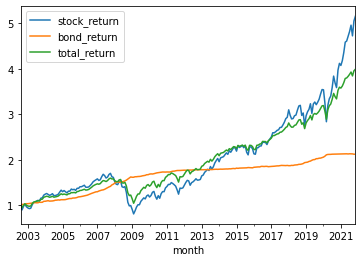

In [193]:
monthly['allocation'] = [stock_bond_allocation(df[df.index < date]['Close'][stock_ticker], p=p, q=q) for date in monthly.index.to_timestamp()]

monthly['total_return'] = monthly['allocation'] * monthly['stock_return'] + (1 - monthly['allocation']) * monthly['bond_return']
monthly[['stock_return', 'bond_return', 'total_return']].cumprod().plot()